This Notebook handles the implementation of Methods 1-4 for dataset 2

It start with a baseline of the ROUGE scores with no summary performed and the the methods are:

- First k sentences
- Word Frequency
- TextRank
- LSA

Link notebook to google to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Change directory to the project directory

In [2]:
cd '/content/drive/My Drive/tfm/'

/content/drive/My Drive/tfm


In [ ]:
!pip install rouge

# Read the Data

In [ ]:
import pandas as pd
import numpy as np

train = pd.read_pickle('./datasets/cnn_dailymail/cnn_dailymail_train_data.txt')
# val = pd.read_pickle('./datasets/cnn_dailymail/cnn_dailymail_val_data.txt')
test = pd.read_pickle('./datasets/cnn_dailymail/cnn_dailymail_test_data.txt')

# train_full = train + val

## Initial preprocessing common to all methods

we already check for null inputs then we will subtitute the english contractions to its longer version

In [ ]:
contraction_mapping = {"ain’t": "is not", "aren’t": "are not","can’t": "cannot", "’cause": "because", "could’ve": "could have", "couldn’t": "could not",

                           "didn’t": "did not", "doesn’t": "does not", "don’t": "do not", "hadn’t": "had not", "hasn’t": "has not", "haven’t": "have not",

                           "he’d": "he would","he’ll": "he will", "he’s": "he is", "how’d": "how did", "how’d’y": "how do you", "how’ll": "how will", "how’s": "how is",

                           "I’d": "I would", "I’d’ve": "I would have", "I’ll": "I will", "I’ll’ve": "I will have","I’m": "I am", "I’ve": "I have", "i’d": "i would",

                           "i’d’ve": "i would have", "i’ll": "i will",  "i’ll’ve": "i will have","i’m": "i am", "i’ve": "i have", "isn’t": "is not", "it’d": "it would",

                           "it’d’ve": "it would have", "it’ll": "it will", "it’ll’ve": "it will have","it’s": "it is", "let’s": "let us", "ma’am": "madam",

                           "mayn’t": "may not", "might’ve": "might have","mightn’t": "might not","mightn’t’ve": "might not have", "must’ve": "must have",

                           "mustn’t": "must not", "mustn’t’ve": "must not have", "needn’t": "need not", "needn’t’ve": "need not have","o’clock": "of the clock",

                           "oughtn’t": "ought not", "oughtn’t’ve": "ought not have", "shan’t": "shall not", "sha’n’t": "shall not", "shan’t’ve": "shall not have",

                           "she’d": "she would", "she’d’ve": "she would have", "she’ll": "she will", "she’ll’ve": "she will have", "she’s": "she is",

                           "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have", "so’ve": "so have","so’s": "so as",

                           "this’s": "this is","that’d": "that would", "that’d’ve": "that would have", "that’s": "that is", "there’d": "there would",

                           "there’d’ve": "there would have", "there’s": "there is", "here’s": "here is","they’d": "they would", "they’d’ve": "they would have",

                           "they’ll": "they will", "they’ll’ve": "they will have", "they’re": "they are", "they’ve": "they have", "to’ve": "to have",

                           "wasn’t": "was not", "we’d": "we would", "we’d’ve": "we would have", "we’ll": "we will", "we’ll’ve": "we will have", "we’re": "we are",

                           "we’ve": "we have", "weren’t": "were not", "what’ll": "what will", "what’ll’ve": "what will have", "what’re": "what are",

                           "what’s": "what is", "what’ve": "what have", "when’s": "when is", "when’ve": "when have", "where’d": "where did", "where’s": "where is",

                           "where’ve": "where have", "who’ll": "who will", "who’ll’ve": "who will have", "who’s": "who is", "who’ve": "who have",

                           "why’s": "why is", "why’ve": "why have", "will’ve": "will have", "won’t": "will not", "won’t’ve": "will not have",

                           "would’ve": "would have", "wouldn’t": "would not", "wouldn’t’ve": "would not have", "y’all": "you all",

                           "y’all’d": "you all would","y’all’d’ve": "you all would have","y’all’re": "you all are","y’all’ve": "you all have",

                           "you’d": "you would", "you’d’ve": "you would have", "you’ll": "you will", "you’ll’ve": "you will have",

                           "you’re": "you are", "you’ve": "you have",
                           '\'':'', '"':'','\n':'' ,'“':''}

In [ ]:
for key,val in contraction_mapping.items():
    for i in range(len(train_full)):
        train_full[i][0] = train_full[i][0].replace(key, val)
        train_full[i][1] = train_full[i][1].replace(key, val)

    for i in range(len(test)):
        test[i][0] = test[i][0].replace(key, val)
        test[i][1] = test[i][1].replace(key, val)

Save the preprocessing just done to be able to read and not repeate this step each time the notebook is connected to an instance

In [ ]:
import os
import pickle

os.chdir("/content/drive/My Drive/tfm/datasets/cnn_dailymail") 


with open("train_full_data.txt", "wb") as fp:   #Pickling
    pickle.dump(train_full,fp)

with open("test_data.txt", "wb") as fp:   #Pickling
    pickle.dump(test, fp)

# Read after prepro

In [4]:
import pandas as pd
train_full = pd.read_pickle('./datasets/cnn_dailymail/train_full_data.txt')
test = pd.read_pickle('./datasets/cnn_dailymail/test_data.txt')

# Method 0: No summary

In [ ]:
df = test
from rouge import Rouge
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
hist_1 = []
hist_2 =[]
hist_l =[]
for i in range(0,len(df)):
    if (i%5000==0):
        print(i)
    scores1 = rouge.get_scores(df[i][1],df[i][0])
    hist_1.append(float(scores1[0]['rouge-1']['f']))
    hist_2.append(float(scores1[0]['rouge-2']['f']))
    hist_l.append(float(scores1[0]['rouge-l']['f']))
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
    
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

import matplotlib.pyplot as plt
import numpy as np

def get_conf_int(hist,alpha):
    # confidence intervals
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(hist, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(hist, p))
    return lower,upper


alpha = 0.9
lower1,upper1 = get_conf_int(hist_1,alpha)
lower2,upper2 = get_conf_int(hist_2,alpha)
lower3,upper3 = get_conf_int(hist_l,alpha)

print('Rouge-1:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (rouge_1,alpha*100, lower1, upper1))
print('Rouge-2:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (rouge_2,alpha*100, lower2, upper2))
print('Rouge-l:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (rouge_l,alpha*100, lower3, upper3))

0
3000
6000
9000
Rouge-1:
 	 mean: 0.1372 
 	 Confidence interval: 90 %  [0.051 , 0.269]
Rouge-2:
 	 mean: 0.0749 
 	 Confidence interval: 90 %  [0.018 , 0.177]
Rouge-l:
 	 mean: 0.2061 
 	 Confidence interval: 90 %  [0.089 , 0.365]


In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(30,6))
ax1.set_title("Rouge 1")
ax2.set_title("Rouge 2")
ax3.set_title("Rouge L")
_ = ax1.hist(hist_1,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax2.hist(hist_2,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax3.hist(hist_l,bins=50,range=(0,1),density=True,color="#3299CC")

# Method 1: First k sentences

## Hypper parameter tunning

Select the number of sentences (k)

### 1

In [9]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from rouge import Rouge

df = train_full
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
hist_1 = []
hist_2 = []
hist_l = []
for i in range(0,len(df)):#50000):
    if(i%50000==0):print(i)
    temp = sent_tokenize(df[i][1])
    temp = temp[0]
   
    scores1 = rouge.get_scores(temp,df[i][0])

    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
    
rouge_1/=len(df)
rouge_2/=len(df)
rouge_l/=len(df)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
0
50000
100000
150000
200000
250000
300000
rouge-1:  0.1476538100199402
rouge-2:  0.049820334242077734
rouge-l:  0.13817501225092174


### 2

In [ ]:
# import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from rouge import Rouge

df = train_full
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
hist_1 = []
hist_2 = []
hist_l = []
for i in range(0,len(df)):#50000):
    if(i%50000==0):print(i)
    temp = sent_tokenize(df[i][1])
    if(len(temp)>=2):
        temp = temp[0] + ' ' +temp[1]

    else:
        temp = temp[0]
   
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
    
rouge_1/=len(df)
rouge_2/=len(df)
rouge_l/=len(df)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
50000
100000
150000
200000
250000
rouge-1:  0.19088279886914364
rouge-2:  0.07216113942626046
rouge-l:  0.17955025715072143


### 3

In [ ]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from rouge import Rouge

df = train_full
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
hist_1 = []
hist_2 = []
hist_l = []
for i in range(0,len(df)):#50000):
    if(i%50000==0):print(i)
    temp = sent_tokenize(df[i][1])
    if (len(temp)>=3):
        temp = temp[0] + ' ' +temp[1]+ ' ' +temp[2]
    else:
        if (len(temp)>=2):
            temp = temp[0] + ' ' +temp[1]
        else:
            temp = temp[0]
   
    scores1 = rouge.get_scores(temp,df[i][0])
    hist_1.append(float(scores1[0]['rouge-1']['f']))
    hist_2.append(float(scores1[0]['rouge-2']['f']))
    hist_l.append(float(scores1[0]['rouge-l']['f']))
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
    
rouge_1/=len(df)
rouge_2/=len(df)
rouge_l/=len(df)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
50000
100000
150000
200000
250000
rouge-1:  0.22423715849751413
rouge-2:  0.08771728791278527
rouge-l:  0.2149844832451507


### 4

In [7]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from rouge import Rouge

df = train_full
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
hist_1 = []
hist_2 = []
hist_l = []
for i in range(0,len(df)):#50000):
    if(i%50000==0):print(i)
    temp = sent_tokenize(df[i][1])
    if (len(temp)>=4):
        temp = temp[0] + ' ' +temp[1]+ ' ' +temp[2]+ ' ' +temp[3]
    else:
        if (len(temp)>=3):
            temp = temp[0] + ' ' +temp[1]+ ' ' +temp[2]
        else:
            if (len(temp)>=2):
                temp = temp[0] + ' ' +temp[1]
            else:
                temp = temp[0]
   
    scores1 = rouge.get_scores(temp,df[i][0])
    hist_1.append(float(scores1[0]['rouge-1']['f']))
    hist_2.append(float(scores1[0]['rouge-2']['f']))
    hist_l.append(float(scores1[0]['rouge-l']['f']))
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
    
rouge_1/=len(df)
rouge_2/=len(df)
rouge_l/=len(df)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
50000
100000
150000
200000
250000
300000
rouge-1:  0.2442043740702498
rouge-2:  0.0995738086917934
rouge-l:  0.24053795002173817


### 5

In [ ]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from rouge import Rouge

df = train_full
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
hist_1 = []
hist_2 = []
hist_l = []
for i in range(0,len(df)):#50000):
    if(i%50000==0):print(i)
    temp = sent_tokenize(df[i][1])

    if (len(temp)>=5):
            temp = temp[0] + ' ' +temp[1]+ ' ' +temp[2]+ ' ' +temp[3]+ ' ' +temp[4]
    else:
        if (len(temp)>=4):
            temp = temp[0] + ' ' +temp[1]+ ' ' +temp[2]+ ' ' +temp[3]
        else:
            if (len(temp)>=3):
                temp = temp[0] + ' ' +temp[1]+ ' ' +temp[2]
            else:
                if (len(temp)>=2):
                    temp = temp[0] + ' ' +temp[1]
                else:
                    temp = temp[0]
   
    scores1 = rouge.get_scores(temp,df[i][0])
    hist_1.append(float(scores1[0]['rouge-1']['f']))
    hist_2.append(float(scores1[0]['rouge-2']['f']))
    hist_l.append(float(scores1[0]['rouge-l']['f']))
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
    
rouge_1/=len(df)
rouge_2/=len(df)
rouge_l/=len(df)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
50000
100000
150000
200000
250000
rouge-1:  0.23581253447619305
rouge-2:  0.09845496083959243
rouge-l:  0.23847899754874646


### 6

In [8]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from rouge import Rouge

df = train_full
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
hist_1 = []
hist_2 = []
hist_l = []
for i in range(0,len(df)):#50000):
    if(i%50000==0):print(i)
    temp = sent_tokenize(df[i][1])
    if (len(temp)>=6):
        temp = temp[0] + ' ' +temp[1]+ ' ' +temp[2]+ ' ' +temp[3]+ ' ' +temp[4] + ' '+temp[5]

    else:
        if (len(temp)>=5):
                temp = temp[0] + ' ' +temp[1]+ ' ' +temp[2]+ ' ' +temp[3]+ ' ' +temp[4]
        else:
            if (len(temp)>=4):
                temp = temp[0] + ' ' +temp[1]+ ' ' +temp[2]+ ' ' +temp[3]
            else:
                if (len(temp)>=3):
                    temp = temp[0] + ' ' +temp[1]+ ' ' +temp[2]
                else:
                    if (len(temp)>=2):
                        temp = temp[0] + ' ' +temp[1]
                    else:
                        temp = temp[0]
   
    scores1 = rouge.get_scores(temp,df[i][0])
    hist_1.append(float(scores1[0]['rouge-1']['f']))
    hist_2.append(float(scores1[0]['rouge-2']['f']))
    hist_l.append(float(scores1[0]['rouge-l']['f']))
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
    
rouge_1/=len(df)
rouge_2/=len(df)
rouge_l/=len(df)

print("rouge-1: ",rouge_1)
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
50000
100000
150000
200000
250000
300000
rouge-1:  0.23593066400615756
rouge-2:  0.10167128677759435
rouge-l:  0.2465238196216979


## test first k sentences

In [ ]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from rouge import Rouge

df = test
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
hist_1 = []
hist_2 = []
hist_l = []
temp2 = []
rouge_recall=0
rouge_precision=0
for i in range(0,len(df)):
    if(i%50000==0):print(i)
    temp = sent_tokenize(df[i][1])
    if (len(temp)>=4):
        temp = temp[0] + ' ' +temp[1]+ ' ' +temp[2]+' '+temp[3]
    else:
        if (len(temp)>=3):
            temp = temp[0] + ' ' +temp[1]+ ' ' +temp[2]
        else:
            if (len(temp)>=2):
                temp = temp[0] + ' ' +temp[1]
            else:
                temp = temp[0]
    temp2.append(temp)
    scores1 = rouge.get_scores(temp,df[i][0])
    hist_1.append(float(scores1[0]['rouge-1']['f']))
    hist_2.append(float(scores1[0]['rouge-2']['f']))
    hist_l.append(float(scores1[0]['rouge-l']['f']))
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
    
rouge_1/=len(df)
rouge_2/=len(df)
rouge_l/=len(df)



import matplotlib.pyplot as plt
import numpy as np

def get_conf_int(hist,alpha):
    # confidence intervals
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(hist, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(hist, p))
    return lower,upper


alpha = 0.9
lower1,upper1 = get_conf_int(hist_1,alpha)
lower2,upper2 = get_conf_int(hist_2,alpha)
lower3,upper3 = get_conf_int(hist_l,alpha)

print('Rouge-1:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (rouge_1,alpha*100, lower1, upper1))
print('Rouge-2:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (rouge_2,alpha*100, lower2, upper2))
print('Rouge-l:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (rouge_l,alpha*100, lower3, upper3))

0
Rouge-1:
 	 mean: 0.3420 
 	 Confidence interval: 90 %  [0.165 , 0.525]
Rouge-2:
 	 mean: 0.1487 
 	 Confidence interval: 90 %  [0.017 , 0.342]
Rouge-l:
 	 mean: 0.3420 
 	 Confidence interval: 90 %  [0.153 , 0.549]


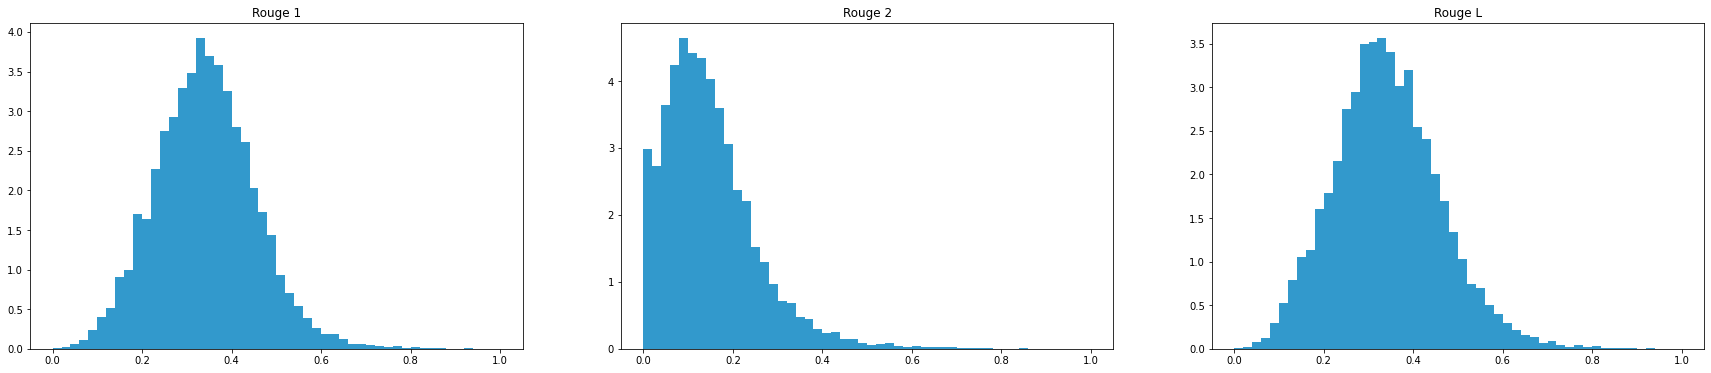

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(30,6))
ax1.set_title("Rouge 1")
ax2.set_title("Rouge 2")
ax3.set_title("Rouge L")
_ = ax1.hist(hist_1,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax2.hist(hist_2,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax3.hist(hist_l,bins=50,range=(0,1),density=True,color="#3299CC")

In [ ]:
fisrt_k_summaries = temp2

# Method 2: Word Frequency 

adaption of the code from https://becominghuman.ai/text-summarization-in-5-steps-using-nltk-65b21e352b65



Remove the stop words, then score the words, then scores the sentences according to its scores, select a threshold value and select the sentences with score above the threshold

## implementation

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# create frequency table
def _create_frequency_table(text_string) -> dict:


    stopWords = set(stopwords.words("english"))
    words = word_tokenize(text_string)
    ps = PorterStemmer()

    freqTable = dict()
    for word in words:
        word = ps.stem(word)
        if word in stopWords:
            continue
        if word in freqTable:
            freqTable[word] += 1
        else:
            freqTable[word] = 1

    return freqTable

# Score the sentences: Term frequency

def _score_sentences(sentences, freqTable,char1) -> dict:
    sentenceValue = dict()

    for sentence in sentences:
        word_count_in_sentence = (len(word_tokenize(sentence)))
        for wordValue in freqTable:
            if wordValue in sentence.lower():
                if sentence[:char1] in sentenceValue:
                    sentenceValue[sentence[:char1]] += freqTable[wordValue]
                else:
                    sentenceValue[sentence[:char1]] = freqTable[wordValue]

        try:
            sentenceValue[sentence[:char1]] = sentenceValue[sentence[:char1]] / word_count_in_sentence
        except:
            print("")

    return sentenceValue

# Find the htreshold score
def _find_average_score(sentenceValue) -> int:
    sumValues = 0
    c = 0
    for entry in sentenceValue:
        sumValues += sentenceValue[entry]

    # Average value of a sentence from original text
    average = int(sumValues / len(sentenceValue))

        # print("sentence value =", len(sentenceValue))
        # print("sumValues = ",sumValues)
    return average

#Generate summary

def _generate_summary(sentences, sentenceValue, threshold):
    sentence_count = 0
    summary = ''

    for sentence in sentences:
        if sentence[:10] in sentenceValue and sentenceValue[sentence[:10]] > (threshold):
            summary += " " + sentence
            sentence_count += 1

    return summary

## Hyperparameter tuning since no training is requieres train_full = train + validation splits

In [ ]:
# mirarr dicionarios y ver que pasa
df =train_full


from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

final =[]

for j in [0.8,1,1.5]:
    print(j)
    generated_summaries =[]
   
    for i in range(len(df)):
        if(i%40000==0):print(i)
        text = df[i][1]
        # 1 Create the word frequency table
        freq_table = _create_frequency_table(text)
        '''
        We already have a sentence tokenizer, so we just need 
        to run the sent_tokenize() method to create the array of sentences.
        '''
        # 2 Tokenize the sentences
        sentences = sent_tokenize(text)
        # 3 Important Algorithm: score the sentences
        sentence_scores = _score_sentences(sentences, freq_table,10)   
        # 4 Find the threshold
        threshold = _find_average_score(sentence_scores)
        # 5 Important Algorithm: Generate the summary
        summary = _generate_summary(sentences, sentence_scores, j * threshold)
        
        if(len(summary)<1):
            summary = _generate_summary(sentences, sentence_scores, 0.99 * threshold)

        generated_summaries.append(summary)
    final.append(generated_summaries)
    

0.8
0
40000

80000
120000

160000

200000
240000
280000
1
0
40000

80000
120000

160000

200000
240000
280000
1.5
0
40000

80000
120000

160000

200000
240000
280000


In [ ]:
from rouge import Rouge

final_scores=[]
for x in range(len(final)):
    print(x)
    rouge = Rouge()
    rouge_1 = 0
    rouge_2 = 0
    rouge_l = 0

    for i in range(0,len(final[x])):
        if (i%40000==0):
            print(i)
        scores1 = rouge.get_scores(final[x][i],train_full[i][0])
        
        rouge_1 +=float(scores1[0]['rouge-1']['f'])
        rouge_2 +=float(scores1[0]['rouge-2']['f'])
        rouge_l +=float(scores1[0]['rouge-l']['f'])
        
    rouge_1 /=len(generated_summaries)
    rouge_2 /=len(generated_summaries)
    rouge_l /=len(generated_summaries)

    final_scores.append([rouge_1,rouge_2,rouge_l])

0
40000
80000
120000
160000
200000
240000
280000
0
40000
80000
120000
160000
200000
240000
280000
0
40000
80000
120000
160000
200000
240000
280000


In [ ]:
final_scores # [0.8,1,1.5]  The best is 1.1

[[0.16613638371848374, 0.07006459927727278, 0.20797176380611565],
 [0.18256737116831068, 0.06618638102907135, 0.20809927535041492],
 [0.1391736986781294, 0.03854934004371045, 0.14154990150391195]]

## Test word Freq


In [ ]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
c1=0
df = test
generated_summaries =[]
for i in range(0,len(df)):
    if (i%5000==0):
        print(i)
    text = df[i][1]
    # 1 Create the word frequency table
    freq_table = _create_frequency_table(text)
    '''
    We already have a sentence tokenizer, so we just need 
    to run the sent_tokenize() method to create the array of sentences.
    '''
    # 2 Tokenize the sentences
    sentences = sent_tokenize(text)
    # 3 Important Algorithm: score the sentences
    sentence_scores = _score_sentences(sentences, freq_table,10)   
    # 4 Find the threshold
    threshold = _find_average_score(sentence_scores)
    # 5 Important Algorithm: Generate the summary
    summary = _generate_summary(sentences, sentence_scores, 1 * threshold)
    
    if(len(summary)<1):
        summary = _generate_summary(sentences, sentence_scores, 0.99 * threshold)

    generated_summaries.append(summary)
    
from rouge import Rouge
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
hist_1 = []
hist_2 =[]
hist_l =[]
for i in range(0,len(generated_summaries)):
    if (i%5000==0):
        print(i)
    scores1 = rouge.get_scores(generated_summaries[i],df[i][0])
    hist_1.append(float(scores1[0]['rouge-1']['f']))
    hist_2.append(float(scores1[0]['rouge-2']['f']))
    hist_l.append(float(scores1[0]['rouge-l']['f']))
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
    
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) 
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
5000
10000
0
5000
10000
rouge-1:  0.19943604600627343
rouge-2:  0.0874736901726303
rouge-l:  0.24761927697980876


statistical significance

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def get_conf_int(hist,alpha):
    # confidence intervals
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(hist, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(hist, p))
    return lower,upper


alpha = 0.9
lower1,upper1 = get_conf_int(hist_1,alpha)
lower2,upper2 = get_conf_int(hist_2,alpha)
lower3,upper3 = get_conf_int(hist_l,alpha)

print('Rouge-1:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (rouge_1,alpha*100, lower1, upper1))
print('Rouge-2:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (rouge_2,alpha*100, lower2, upper2))
print('Rouge-l:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (rouge_l,alpha*100, lower3, upper3))

Rouge-1:
 	 mean: 0.1994 
 	 Confidence interval: 90 %  [0.084 , 0.356]
Rouge-2:
 	 mean: 0.0875 
 	 Confidence interval: 90 %  [0.010 , 0.208]
Rouge-l:
 	 mean: 0.2476 
 	 Confidence interval: 90 %  [0.109 , 0.416]


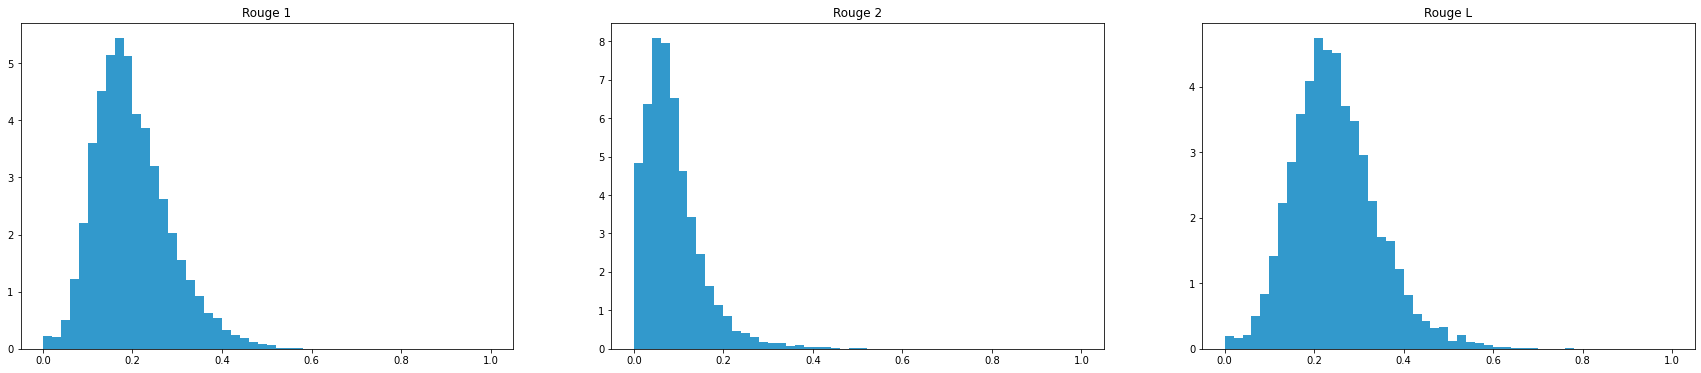

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(30,6))
ax1.set_title("Rouge 1")
ax2.set_title("Rouge 2")
ax3.set_title("Rouge L")
_ = ax1.hist(hist_1,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax2.hist(hist_2,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax3.hist(hist_l,bins=50,range=(0,1),density=True,color="#3299CC")

In [ ]:
word_freq_summ = generated_summaries 

# PyTLDR

For the next 2 methods we will use the python library PyTLDR: https://pypi.org/project/PyTLDR/

Go to the code directory

In [ ]:
cd /content/drive/My Drive/tfm/PyTLDR

/content/drive/My Drive/tfm/PyTLDR


Install it, it should be already downloaded from the other dataset 1

In [ ]:
!python setup.py install

# Method 3: TextRank

to avoid recursion limit error

In [ ]:
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(3000)
print(sys.getrecursionlimit())

1000
3000


### Hyperparameter tuning

In [ ]:
from pytldr.summarize import TextRankSummarizer
from pytldr.nlp import Tokenizer

tokenizer = Tokenizer('english')
summarizer = TextRankSummarizer(tokenizer)

# If you don't specify a tokenizer when intiializing a summarizer then the
# English tokenizer will be used by default
summarizer = TextRankSummarizer()  # English tokenizer used

# This object creates a summary using the summarize method:
# e.g. summarizer.summarize(text, length=5, weighting='frequency', norm=None)

# The length parameter specifies the length of the summary, either as a
# number of sentences, or a percentage of the original text

# The summarizer can take as input...
# 1. A string:

df = train_full
generated_summaries =[]
for i in range (0,50000):
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], length=0.2)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.3)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.4)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.5)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.6)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.7)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.8)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.9)
    #if(len(sum)< 4): print(i)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)
    #generated_summaries.append(sum)

from rouge import Rouge

rouge_1= 0
rouge_2= 0
rouge_l= 0
rouge = Rouge()
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)
    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1];print("look: ",i)
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
20000
40000
0
20000
40000
rouge-1:  0.24561071696315942
rouge-2:  0.09115701692350005
rouge-l:  0.2533682003667685


In [ ]:
from pytldr.summarize import TextRankSummarizer
from pytldr.nlp import Tokenizer

tokenizer = Tokenizer('english')
summarizer = TextRankSummarizer(tokenizer)


summarizer = TextRankSummarizer()  # English tokenizer used

df = train_full
generated_summaries =[]
for i in range (0,50000):
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], length=0.4)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.5)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.6)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.7)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.8)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.9)
    #if(len(sum)< 4): print(i)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge

rouge_1= 0
rouge_2= 0
rouge_l= 0
rouge = Rouge()
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)
    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1];print("look: ",i)
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.4
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
20000
40000
0
20000
40000
rouge-1:  0.20305978107774011
rouge-2:  0.08656122209024092
rouge-l:  0.23897915586025167


In [ ]:
from pytldr.summarize import TextRankSummarizer
from pytldr.nlp import Tokenizer

tokenizer = Tokenizer('english')
summarizer = TextRankSummarizer(tokenizer)

# If you don't specify a tokenizer when intiializing a summarizer then the
# English tokenizer will be used by default
summarizer = TextRankSummarizer()  # English tokenizer used

# This object creates a summary using the summarize method:
# e.g. summarizer.summarize(text, length=5, weighting='frequency', norm=None)

# The length parameter specifies the length of the summary, either as a
# number of sentences, or a percentage of the original text

# The summarizer can take as input...
# 1. A string:

df = train_full
generated_summaries =[]
for i in range (0,50000):
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], length=0.6)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.7)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.8)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.9)
    #if(len(sum)< 4): print(i)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge

rouge_1= 0
rouge_2= 0
rouge_l= 0
rouge = Rouge()
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)
    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1];print("look: ",i)
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
20000
40000
0
20000
40000
rouge-1:  0.1738122382487998
rouge-2:  0.08039289038898519
rouge-l:  0.22155345838429924


In [ ]:
from pytldr.summarize import TextRankSummarizer
from pytldr.nlp import Tokenizer

tokenizer = Tokenizer('english')
summarizer = TextRankSummarizer(tokenizer)

# If you don't specify a tokenizer when intiializing a summarizer then the
# English tokenizer will be used by default
summarizer = TextRankSummarizer()  # English tokenizer used

# This object creates a summary using the summarize method:
# e.g. summarizer.summarize(text, length=5, weighting='frequency', norm=None)

# The length parameter specifies the length of the summary, either as a
# number of sentences, or a percentage of the original text

# The summarizer can take as input...
# 1. A string:

df = train_full
generated_summaries =[]
for i in range (0,50000):
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], length=0.8)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.9)
    #if(len(sum)< 4): print(i)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge

rouge_1= 0
rouge_2= 0
rouge_l= 0
rouge = Rouge()
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)
    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1];print("look: ",i)
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
20000
40000
0
20000
40000
rouge-1:  0.15366875185802503
rouge-2:  0.0751517489038519
rouge-l:  0.2068156798253143


In [ ]:
from pytldr.summarize import TextRankSummarizer
from pytldr.nlp import Tokenizer

tokenizer = Tokenizer('english')
summarizer = TextRankSummarizer(tokenizer)

# If you don't specify a tokenizer when intiializing a summarizer then the
# English tokenizer will be used by default
summarizer = TextRankSummarizer()  # English tokenizer used

# This object creates a summary using the summarize method:
# e.g. summarizer.summarize(text, length=5, weighting='frequency', norm=None)

# The length parameter specifies the length of the summary, either as a
# number of sentences, or a percentage of the original text

# The summarizer can take as input...
# 1. A string:

df = train_full
generated_summaries =[]
for i in range (0,50000):
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], length=0.1)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.2)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.3)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.4)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.5)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.6)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.7)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.8)
    if(len(sum)<1): sum = summarizer.summarize(df[i][1], length=0.9)
    #if(len(sum)< 4): print(i)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge

rouge_1= 0
rouge_2= 0
rouge_l= 0
rouge = Rouge()
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)
    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1];print("look: ",i)
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
20000
40000
0
20000
40000
rouge-1:  0.2597767422786583
rouge-2:  0.08586093202671684
rouge-l:  0.24431450601290639


In [ ]:
from pytldr.summarize import TextRankSummarizer
from pytldr.nlp import Tokenizer

tokenizer = Tokenizer('english')
summarizer = TextRankSummarizer(tokenizer)

# If you don't specify a tokenizer when intiializing a summarizer then the
# English tokenizer will be used by default
summarizer = TextRankSummarizer()  # English tokenizer used

# This object creates a summary using the summarize method:
# e.g. summarizer.summarize(text, length=5, weighting='frequency', norm=None)

# The length parameter specifies the length of the summary, either as a
# number of sentences, or a percentage of the original text

# The summarizer can take as input...
# 1. A string:

df = train_full
generated_summaries =[]
for i in range (0,50000):
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], length=2)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge

rouge_1= 0
rouge_2= 0
rouge_l= 0
rouge = Rouge()
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)
    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1];print("look: ",i)
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
20000
40000
0
20000
40000
rouge-1:  0.2674244211301462
rouge-2:  0.08713050200946416
rouge-l:  0.24754234054759772


In [ ]:
from pytldr.summarize import TextRankSummarizer
from pytldr.nlp import Tokenizer

tokenizer = Tokenizer('english')
summarizer = TextRankSummarizer(tokenizer)

# If you don't specify a tokenizer when intiializing a summarizer then the
# English tokenizer will be used by default
summarizer = TextRankSummarizer()  # English tokenizer used

# This object creates a summary using the summarize method:
# e.g. summarizer.summarize(text, length=5, weighting='frequency', norm=None)

# The length parameter specifies the length of the summary, either as a
# number of sentences, or a percentage of the original text

# The summarizer can take as input...
# 1. A string:

df = train_full
generated_summaries =[]
for i in range (0,50000):
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], length=1)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge

rouge_1= 0
rouge_2= 0
rouge_l= 0
rouge = Rouge()
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)
    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1];print("look: ",i)
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
20000
40000
0
20000
40000
rouge-1:  0.23622767098448294
rouge-2:  0.072564688721871
rouge-l:  0.21332848862196868


In [ ]:
from pytldr.summarize import TextRankSummarizer
from pytldr.nlp import Tokenizer

tokenizer = Tokenizer('english')
summarizer = TextRankSummarizer(tokenizer)

# If you don't specify a tokenizer when intiializing a summarizer then the
# English tokenizer will be used by default
summarizer = TextRankSummarizer()  # English tokenizer used

# This object creates a summary using the summarize method:
# e.g. summarizer.summarize(text, length=5, weighting='frequency', norm=None)

# The length parameter specifies the length of the summary, either as a
# number of sentences, or a percentage of the original text

# The summarizer can take as input...
# 1. A string:

df = train_full
generated_summaries =[]
for i in range (0,50000):
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], length=3)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge

rouge_1= 0
rouge_2= 0
rouge_l= 0
rouge = Rouge()
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)
    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1];print("look: ",i)
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
20000
40000
0
20000
40000
rouge-1:  0.26595323502734197
rouge-2:  0.09189009882934684
rouge-l:  0.2575170333485767


In [ ]:
from pytldr.summarize import TextRankSummarizer
from pytldr.nlp import Tokenizer

tokenizer = Tokenizer('english')
summarizer = TextRankSummarizer(tokenizer)

# If you don't specify a tokenizer when intiializing a summarizer then the
# English tokenizer will be used by default
summarizer = TextRankSummarizer()  # English tokenizer used

# This object creates a summary using the summarize method:
# e.g. summarizer.summarize(text, length=5, weighting='frequency', norm=None)

# The length parameter specifies the length of the summary, either as a
# number of sentences, or a percentage of the original text

# The summarizer can take as input...
# 1. A string:

df = train_full
generated_summaries =[]
for i in range (0,50000):
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], length=4)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)
from rouge import Rouge

rouge_1= 0
rouge_2= 0
rouge_l= 0
rouge = Rouge()
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)
    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1];print("look: ",i)
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
20000
40000
0
20000
40000
rouge-1:  0.2555279584523961
rouge-2:  0.09280494047234461
rouge-l:  0.2586736729916822


### test text rank

In [ ]:
from pytldr.summarize import TextRankSummarizer
from pytldr.nlp import Tokenizer

tokenizer = Tokenizer('english')
summarizer = TextRankSummarizer(tokenizer)

df = test
# let's begin
generated_sum = []
for i in range(0,len(df)):
    if(i%20000==0):print(i)
    sum = summarizer.summarize(df[i][1], length=2)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_sum.append(sum2)

from rouge import Rouge
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
hist_1 = []
hist_2 = []
hist_l = []
for i in range(0,len(generated_sum)):
    if(i%20000==0):print(i)
    temp = generated_sum[i]
    if (len(temp)==0):temp = df[i][1]
    scores1 = rouge.get_scores(temp,df[i][0])
    hist_1.append(float(scores1[0]['rouge-1']['f']))
    hist_2.append(float(scores1[0]['rouge-2']['f']))
    hist_l.append(float(scores1[0]['rouge-l']['f']))
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
    
rouge_1/=len(generated_sum)
rouge_2/=len(generated_sum)
rouge_l/=len(generated_sum)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
0
rouge-1:  0.2917626835273952
rouge-2:  0.10222876539647445
rouge-l:  0.27059653632426073


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def get_conf_int(hist,alpha):
    # confidence intervals
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(hist, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(hist, p))
    return lower,upper


alpha = 0.9
lower1,upper1 = get_conf_int(hist_1,alpha)
lower2,upper2 = get_conf_int(hist_2,alpha)
lower3,upper3 = get_conf_int(hist_l,alpha)

print('Rouge-1:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (rouge_1,alpha*100, lower1, upper1))
print('Rouge-2:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (rouge_2,alpha*100, lower2, upper2))
print('Rouge-l:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (rouge_l,alpha*100, lower3, upper3))

Rouge-1:
 	 mean: 0.2918 
 	 Confidence interval: 90 %  [0.125 , 0.489]
Rouge-2:
 	 mean: 0.1022 
 	 Confidence interval: 90 %  [0.000 , 0.289]
Rouge-l:
 	 mean: 0.2706 
 	 Confidence interval: 90 %  [0.113 , 0.483]


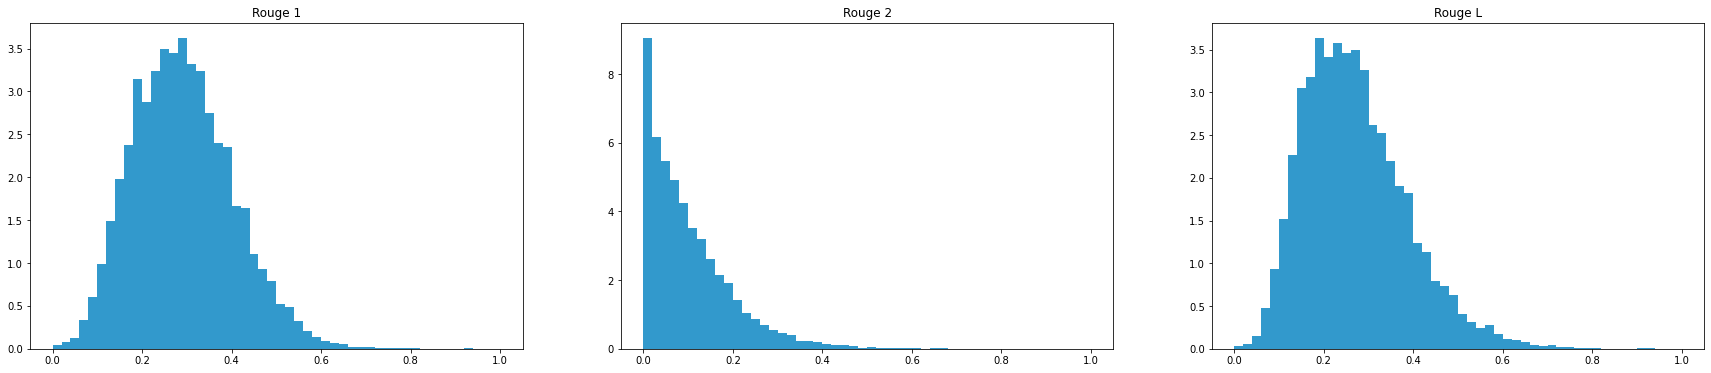

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(30,6))
ax1.set_title("Rouge 1")
ax2.set_title("Rouge 2")
ax3.set_title("Rouge L")
_ = ax1.hist(hist_1,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax2.hist(hist_2,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax3.hist(hist_l,bins=50,range=(0,1),density=True,color="#3299CC")

In [ ]:
textrank_summ = generated_sum

# Method 4: LSA

## Hyperparameter tuning

In [ ]:
from pytldr.summarize import LsaSummarizer, LsaOzsoy, LsaSteinberger

#summarizer = LsaOzsoy()
#summarizer = LsaSteinberger()
summarizer = LsaSummarizer()  # This is identical to the LsaOzsoy object


# topics specifies the number of topics to cluster the article into.
# topic_sigma_threshold removes all topics with a singular value less than a given
# percentage of the largest singular value.

df = train_full
generated_summaries =[]
for i in range (0,50000):
    #print(i)
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], topics=8, length=2, binary_matrix=True)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
final_scores=[]
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)

    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1]
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0


/content/drive/My Drive/tfm/PyTLDR/pytldr/summarize/lsa.py:36: Warning: The parameter "topics" must be <= rank(sentence_matrix) - 1 to avoid rank deficiency in the SVD computation. The number of topics has been adjusted to equal rank(sentence_matrix) - 1 but this could result in a poor summary.
  Warning


20000
40000
0
20000
40000
rouge-1:  0.23193465036624197
rouge-2:  0.06521562026224739
rouge-l:  0.21133980262940713


In [ ]:
from pytldr.summarize import LsaSummarizer, LsaOzsoy, LsaSteinberger

#summarizer = LsaOzsoy()
#summarizer = LsaSteinberger()
summarizer = LsaSummarizer()  # This is identical to the LsaOzsoy object


# topics specifies the number of topics to cluster the article into.
# topic_sigma_threshold removes all topics with a singular value less than a given
# percentage of the largest singular value.

df = train_full
generated_summaries =[]
for i in range (0,50000):
    #print(i)
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], topics=16, length=2, binary_matrix=True)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
final_scores=[]
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)

    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1]
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0


/content/drive/My Drive/tfm/PyTLDR/pytldr/summarize/lsa.py:36: Warning: The parameter "topics" must be <= rank(sentence_matrix) - 1 to avoid rank deficiency in the SVD computation. The number of topics has been adjusted to equal rank(sentence_matrix) - 1 but this could result in a poor summary.
  Warning


20000
40000
0
20000
40000
rouge-1:  0.2291350529366945
rouge-2:  0.06309848556897098
rouge-l:  0.20855645012776056


In [ ]:
from pytldr.summarize import LsaSummarizer, LsaOzsoy, LsaSteinberger

#summarizer = LsaOzsoy()
#summarizer = LsaSteinberger()
summarizer = LsaSummarizer()  # This is identical to the LsaOzsoy object


# topics specifies the number of topics to cluster the article into.
# topic_sigma_threshold removes all topics with a singular value less than a given
# percentage of the largest singular value.

df = train_full
generated_summaries =[]
for i in range (0,50000):
    #print(i)
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], topics=16, length=3, binary_matrix=True)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
final_scores=[]
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)

    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1]
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0


/content/drive/My Drive/tfm/PyTLDR/pytldr/summarize/lsa.py:36: Warning: The parameter "topics" must be <= rank(sentence_matrix) - 1 to avoid rank deficiency in the SVD computation. The number of topics has been adjusted to equal rank(sentence_matrix) - 1 but this could result in a poor summary.
  Warning


20000
40000
0
20000
40000
rouge-1:  0.23552707110704202
rouge-2:  0.07003307206269126
rouge-l:  0.22134169334713352


In [ ]:
from pytldr.summarize import LsaSummarizer, LsaOzsoy, LsaSteinberger

#summarizer = LsaOzsoy()
#summarizer = LsaSteinberger()
summarizer = LsaSummarizer()  # This is identical to the LsaOzsoy object


# topics specifies the number of topics to cluster the article into.
# topic_sigma_threshold removes all topics with a singular value less than a given
# percentage of the largest singular value.

df = train_full
generated_summaries =[]
for i in range (0,50000):
    #print(i)
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], topics=16, length=1, binary_matrix=True)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
final_scores=[]
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)

    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1]
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0


/content/drive/My Drive/tfm/PyTLDR/pytldr/summarize/lsa.py:36: Warning: The parameter "topics" must be <= rank(sentence_matrix) - 1 to avoid rank deficiency in the SVD computation. The number of topics has been adjusted to equal rank(sentence_matrix) - 1 but this could result in a poor summary.
  Warning


20000
40000
0
20000
40000
rouge-1:  0.19145638433906123
rouge-2:  0.04770762796909556
rouge-l:  0.17103534444360796


In [ ]:
from pytldr.summarize import LsaSummarizer, LsaOzsoy, LsaSteinberger

#summarizer = LsaOzsoy()
#summarizer = LsaSteinberger()
summarizer = LsaSummarizer()  # This is identical to the LsaOzsoy object


# topics specifies the number of topics to cluster the article into.
# topic_sigma_threshold removes all topics with a singular value less than a given
# percentage of the largest singular value.

df = train_full
generated_summaries =[]
for i in range (0,50000):
    #print(i)
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], topics=16, length=4, binary_matrix=True)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
final_scores=[]
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)

    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1]
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0


/content/drive/My Drive/tfm/PyTLDR/pytldr/summarize/lsa.py:36: Warning: The parameter "topics" must be <= rank(sentence_matrix) - 1 to avoid rank deficiency in the SVD computation. The number of topics has been adjusted to equal rank(sentence_matrix) - 1 but this could result in a poor summary.
  Warning


20000
40000
0
20000
40000
rouge-1:  0.23236835331303762
rouge-2:  0.07361871216180199
rouge-l:  0.22641142226740518


In [ ]:
from pytldr.summarize import LsaSummarizer, LsaOzsoy, LsaSteinberger

#summarizer = LsaOzsoy()
#summarizer = LsaSteinberger()
summarizer = LsaSummarizer()  # This is identical to the LsaOzsoy object


# topics specifies the number of topics to cluster the article into.
# topic_sigma_threshold removes all topics with a singular value less than a given
# percentage of the largest singular value.

df = train_full
generated_summaries =[]
for i in range (0,50000):
    #print(i)
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], topics=8, length=3, binary_matrix=True)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
final_scores=[]
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)

    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1]
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0


/content/drive/My Drive/tfm/PyTLDR/pytldr/summarize/lsa.py:36: Warning: The parameter "topics" must be <= rank(sentence_matrix) - 1 to avoid rank deficiency in the SVD computation. The number of topics has been adjusted to equal rank(sentence_matrix) - 1 but this could result in a poor summary.
  Warning


20000
40000
0
20000
40000
rouge-1:  0.23836580831896773
rouge-2:  0.0726029579300297
rouge-l:  0.225415672462531


In [ ]:
from pytldr.summarize import LsaSummarizer, LsaOzsoy, LsaSteinberger

#summarizer = LsaOzsoy()
#summarizer = LsaSteinberger()
summarizer = LsaSummarizer()  # This is identical to the LsaOzsoy object


# topics specifies the number of topics to cluster the article into.
# topic_sigma_threshold removes all topics with a singular value less than a given
# percentage of the largest singular value.

df = train_full
generated_summaries =[]
for i in range (0,50000):
    #print(i)
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], topics=8, length=4, binary_matrix=True)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
final_scores=[]
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)

    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1]
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0


/content/drive/My Drive/tfm/PyTLDR/pytldr/summarize/lsa.py:36: Warning: The parameter "topics" must be <= rank(sentence_matrix) - 1 to avoid rank deficiency in the SVD computation. The number of topics has been adjusted to equal rank(sentence_matrix) - 1 but this could result in a poor summary.
  Warning


20000
40000
0
20000
40000
rouge-1:  0.23555017148252144
rouge-2:  0.07711679117905865
rouge-l:  0.23165885806804898


In [ ]:
from pytldr.summarize import LsaSummarizer, LsaOzsoy, LsaSteinberger

#summarizer = LsaOzsoy()
#summarizer = LsaSteinberger()
summarizer = LsaSummarizer()  # This is identical to the LsaOzsoy object


# topics specifies the number of topics to cluster the article into.
# topic_sigma_threshold removes all topics with a singular value less than a given
# percentage of the largest singular value.

df = train_full
generated_summaries =[]
for i in range (0,50000):
    #print(i)
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], topics=4, length=4, binary_matrix=True)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
final_scores=[]
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)

    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1]
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0


/content/drive/My Drive/tfm/PyTLDR/pytldr/summarize/lsa.py:36: Warning: The parameter "topics" must be <= rank(sentence_matrix) - 1 to avoid rank deficiency in the SVD computation. The number of topics has been adjusted to equal rank(sentence_matrix) - 1 but this could result in a poor summary.
  Warning


20000
40000
0
20000
40000
rouge-1:  0.24094025109339653
rouge-2:  0.08240586306865298
rouge-l:  0.24182791506408324


In [ ]:
from pytldr.summarize import LsaSummarizer, LsaOzsoy, LsaSteinberger

#summarizer = LsaOzsoy()
#summarizer = LsaSteinberger()
summarizer = LsaSummarizer()  # This is identical to the LsaOzsoy object


# topics specifies the number of topics to cluster the article into.
# topic_sigma_threshold removes all topics with a singular value less than a given
# percentage of the largest singular value.

df = train_full
generated_summaries =[]
for i in range (0,50000):
    #print(i)
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], topics=3, length=4, binary_matrix=True)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
final_scores=[]
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)

    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1]
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
20000
40000
0
20000
40000
rouge-1:  0.2419116456990759
rouge-2:  0.08310522177656356
rouge-l:  0.2437101907330608


In [ ]:
from pytldr.summarize import LsaSummarizer, LsaOzsoy, LsaSteinberger

#summarizer = LsaOzsoy()
#summarizer = LsaSteinberger()
summarizer = LsaSummarizer()  # This is identical to the LsaOzsoy object


# topics specifies the number of topics to cluster the article into.
# topic_sigma_threshold removes all topics with a singular value less than a given
# percentage of the largest singular value.

df = train_full
generated_summaries =[]
for i in range (0,50000):
    #print(i)
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], topics=3, length=3, binary_matrix=True)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
final_scores=[]
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)

    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1]
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
20000


/content/drive/My Drive/tfm/PyTLDR/pytldr/summarize/lsa.py:36: Warning: The parameter "topics" must be <= rank(sentence_matrix) - 1 to avoid rank deficiency in the SVD computation. The number of topics has been adjusted to equal rank(sentence_matrix) - 1 but this could result in a poor summary.
  Warning


40000
0
20000
40000
rouge-1:  0.24672226729087626
rouge-2:  0.08039741700673705
rouge-l:  0.23851348825350974


In [ ]:
from pytldr.summarize import LsaSummarizer, LsaOzsoy, LsaSteinberger

#summarizer = LsaOzsoy()
#summarizer = LsaSteinberger()
summarizer = LsaSummarizer()  # This is identical to the LsaOzsoy object


# topics specifies the number of topics to cluster the article into.
# topic_sigma_threshold removes all topics with a singular value less than a given
# percentage of the largest singular value.

df = train_full
generated_summaries =[]
for i in range (0,50000):
    #print(i)
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], topics=2, length=3, binary_matrix=True)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
final_scores=[]
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)

    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1]
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
20000
40000
0
20000
40000
rouge-1:  0.2470848474141329
rouge-2:  0.08045573398352046
rouge-l:  0.23990597880476183


In [ ]:
from pytldr.summarize import LsaSummarizer, LsaOzsoy, LsaSteinberger

#summarizer = LsaOzsoy()
#summarizer = LsaSteinberger()
summarizer = LsaSummarizer()  # This is identical to the LsaOzsoy object


# topics specifies the number of topics to cluster the article into.
# topic_sigma_threshold removes all topics with a singular value less than a given
# percentage of the largest singular value.

df = train_full
generated_summaries =[]
for i in range (0,50000):
    #print(i)
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], topics=64, length=3, binary_matrix=True)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
final_scores=[]
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)

    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1]
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0


/content/drive/My Drive/tfm/PyTLDR/pytldr/summarize/lsa.py:36: Warning: The parameter "topics" must be <= rank(sentence_matrix) - 1 to avoid rank deficiency in the SVD computation. The number of topics has been adjusted to equal rank(sentence_matrix) - 1 but this could result in a poor summary.
  Warning


20000
40000
0
20000
40000
rouge-1:  0.23583091031242306
rouge-2:  0.07015586708219224
rouge-l:  0.22188803174110816


In [ ]:
from pytldr.summarize import LsaSummarizer, LsaOzsoy, LsaSteinberger

#summarizer = LsaOzsoy()
#summarizer = LsaSteinberger()
summarizer = LsaSummarizer()  # This is identical to the LsaOzsoy object


# topics specifies the number of topics to cluster the article into.
# topic_sigma_threshold removes all topics with a singular value less than a given
# percentage of the largest singular value.

df = train_full
generated_summaries =[]
for i in range (0,50000):
    #print(i)
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], topics=1, length=3, binary_matrix=True)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
final_scores=[]
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)

    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1]
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
20000
40000
0
20000
40000
rouge-1:  0.2460101080368705
rouge-2:  0.07487988982826817
rouge-l:  0.2339851454629641


In [ ]:
from pytldr.summarize import LsaSummarizer, LsaOzsoy, LsaSteinberger

#summarizer = LsaOzsoy()
#summarizer = LsaSteinberger()
summarizer = LsaSummarizer()  # This is identical to the LsaOzsoy object


# topics specifies the number of topics to cluster the article into.
# topic_sigma_threshold removes all topics with a singular value less than a given
# percentage of the largest singular value.

df = train_full
generated_summaries =[]
for i in range (0,50000):
    #print(i)
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], topics=1, length=4, binary_matrix=True)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
final_scores=[]
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)

    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1]
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
20000
40000
0
20000
40000
rouge-1:  0.2419853404363673
rouge-2:  0.07661722149186317
rouge-l:  0.23740656749281508


In [ ]:
from pytldr.summarize import LsaSummarizer, LsaOzsoy, LsaSteinberger

#summarizer = LsaOzsoy()
#summarizer = LsaSteinberger()
summarizer = LsaSummarizer()  # This is identical to the LsaOzsoy object


# topics specifies the number of topics to cluster the article into.
# topic_sigma_threshold removes all topics with a singular value less than a given
# percentage of the largest singular value.

df = train_full
generated_summaries =[]
for i in range (0,50000):
    #print(i)
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], topics=2, length=4, binary_matrix=True)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_summaries.append(sum2)

from rouge import Rouge
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
final_scores=[]
for i in range(0,len(generated_summaries)):
    if (i %20000==0):print(i)

    temp = generated_summaries[i]
    if (len(temp)==0):temp = df[i][1]
    scores1 = rouge.get_scores(temp,df[i][0])
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
        
rouge_1/=len(generated_summaries)
rouge_2/=len(generated_summaries)
rouge_l/=len(generated_summaries)

print("rouge-1: ",rouge_1) # generated summary 0.2
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
20000
40000
0
20000
40000
rouge-1:  0.241825594771668
rouge-2:  0.08198229113386338
rouge-l:  0.24337835922153916


## Test LSA

In [ ]:
from pytldr.summarize import TextRankSummarizer
from pytldr.nlp import Tokenizer
from pytldr.summarize import LsaSummarizer, LsaOzsoy, LsaSteinberger

summarizer = LsaSummarizer()  

df = test
# let's begin
generated_sum = []
for i in range(0,len(df)):
    if (i %20000==0):print(i)
    sum = summarizer.summarize(df[i][1], topics=2, length=3, binary_matrix=True)
    sum2 = ''
    for x in range(len(sum)):
        sum2 +=sum[x]
    generated_sum.append(sum2)


from rouge import Rouge
rouge = Rouge()
rouge_1= 0
rouge_2= 0
rouge_l= 0
hist_1 = []
hist_2 = []
hist_l = []
for i in range(0,len(generated_sum)):
    if(i%20000==0):print(i)
    temp = generated_sum[i]
    if (len(temp)==0):temp = df[i][1]
    scores1 = rouge.get_scores(temp,df[i][0])

    hist_1.append(float(scores1[0]['rouge-1']['f']))
    hist_2.append(float(scores1[0]['rouge-2']['f']))
    hist_l.append(float(scores1[0]['rouge-l']['f']))
    rouge_1+=float(scores1[0]['rouge-1']['f'])
    rouge_2+=float(scores1[0]['rouge-2']['f'])
    rouge_l+=float(scores1[0]['rouge-l']['f'])
    
rouge_1/=len(generated_sum)
rouge_2/=len(generated_sum)
rouge_l/=len(generated_sum)

print("rouge-1: ",rouge_1) 
print("rouge-2: ",rouge_2)
print("rouge-l: ",rouge_l)

0
0
rouge-1:  0.2688055423227784
rouge-2:  0.09297176101071952
rouge-l:  0.2623944430610935


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def get_conf_int(hist,alpha):
    # confidence intervals
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(hist, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(hist, p))
    return lower,upper


alpha = 0.9
lower1,upper1 = get_conf_int(hist_1,alpha)
lower2,upper2 = get_conf_int(hist_2,alpha)
lower3,upper3 = get_conf_int(hist_l,alpha)

print('Rouge-1:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (rouge_1,alpha*100, lower1, upper1))
print('Rouge-2:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (rouge_2,alpha*100, lower2, upper2))
print('Rouge-l:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (rouge_l,alpha*100, lower3, upper3))

Rouge-1:
 	 mean: 0.2688 
 	 Confidence interval: 90 %  [0.112 , 0.452]
Rouge-2:
 	 mean: 0.0930 
 	 Confidence interval: 90 %  [0.000 , 0.260]
Rouge-l:
 	 mean: 0.2624 
 	 Confidence interval: 90 %  [0.106 , 0.464]


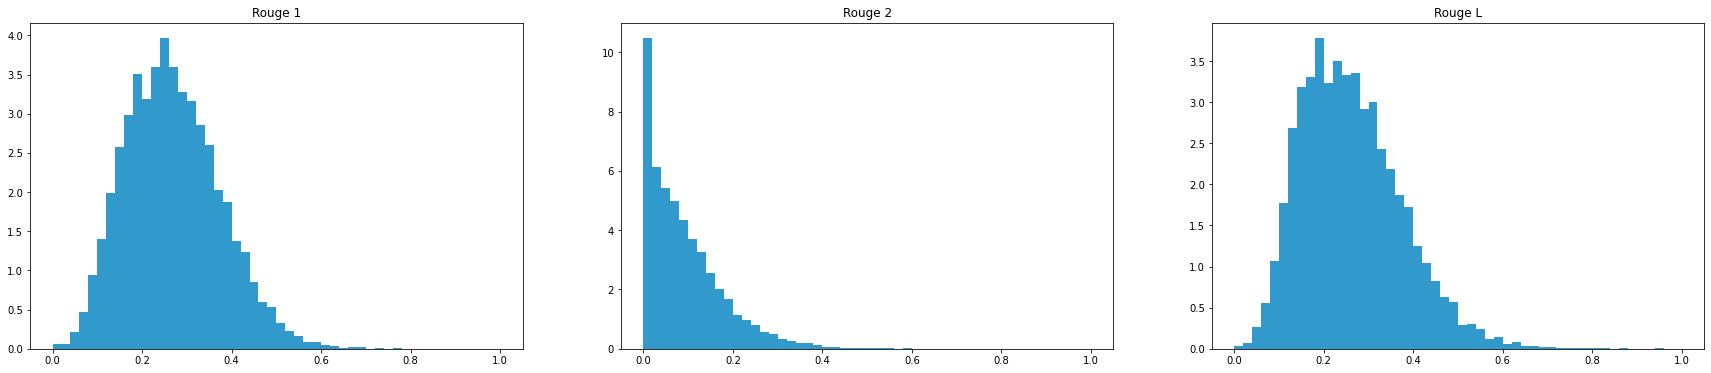

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(30,6))
ax1.set_title("Rouge 1")
ax2.set_title("Rouge 2")
ax3.set_title("Rouge L")
_ = ax1.hist(hist_1,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax2.hist(hist_2,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax3.hist(hist_l,bins=50,range=(0,1),density=True,color="#3299CC")

In [ ]:
lsa_sumaries = generated_sum

# Summaries examples (not run until PreSumm summaries are ready)


In [ ]:
# test
# word_freq_summ
# textrank_summ
# fisrt_k_summaries
# lsa_sumaries

In [ ]:
from rouge import Rouge
rouge = Rouge()

Original text

In [ ]:
x=10697


In [ ]:
a = test[x][1]
print(a)
scores = rouge.get_scores(a,test[x][0])
print("F1 Rouge-1: \t",float(scores[0]['rouge-1']['f']))
print("F1 Rouge-2: \t",float(scores[0]['rouge-2']['f']))
print("F1 Rouge-L: \t",float(scores[0]['rouge-l']['f']))


(CNN)The Force is strong in Turkey -- or at least it appears to be at one university where thousands of students are petitioning for a Jedi temple to be built on campus. The petition, which was started by a student at Dokuz Eylul University in the western province of Izmir, so far has almost 5,500 signatures. There are less and less Jedi left on the Earth, the petition says. It adds that uneducated Padawan -- the novice Jedis in George Lucas Star Wars film franchise -- are moving to the dark side. ... To find the balance in the Force, we want a Jedi temple. The page on Change.org also features a still of Jedi Grand Master Yoda from Star Wars: Episode II -- Attack of the Clones teaching young Jedis how to use a light saber. I am signing because the nearest temple (is) billions of light years away, one supporter wrote on the petition page. Another supporter wrote: We want freedom of worship. There are mosques everywhere, but no Jedi temple! The petition was started by Akin Cagatay Calisk

Human generated summary

In [ ]:
print(test[x][0])

5,500 signatures call for Jedi temple after similar petition asked for campus mosque . Petition started by a student at Dokuz Eylul University in the western province of Izmir .


Word freq 

In [ ]:
a = word_freq_summ[x]
print(a)
scores = rouge.get_scores(a,test[x][0])
print("F1 Rouge-1: \t",float(scores[0]['rouge-1']['f']))
print("F1 Rouge-2: \t",float(scores[0]['rouge-2']['f']))
print("F1 Rouge-L: \t",float(scores[0]['rouge-l']['f']))

 The petition, which was started by a student at Dokuz Eylul University in the western province of Izmir, so far has almost 5,500 signatures. There are less and less Jedi left on the Earth, the petition says. ... To find the balance in the Force, we want a Jedi temple. I am signing because the nearest temple (is) billions of light years away, one supporter wrote on the petition page. Another supporter wrote: We want freedom of worship. There are mosques everywhere, but no Jedi temple! The petition was started by Akin Cagatay Caliskan, an 18-year-old computer science student from Ankara. I thought maybe it might (have) 100. The satirical document does have a serious side. Karaca was referencing another petition asking a mosque be built on campus, which almost 200,000 students signed. Twenty thousand students at ITU also signed a separate petition in response, demanding a Buddhist temple on campus. I want to fulfill my religious needs on campus, said another.
F1 Rouge-1: 	 0.210526313276

Text Rank

In [ ]:
a = textrank_summ[x]
print(a)
scores = rouge.get_scores(a,test[x][0])
print("F1 Rouge-1: \t",float(scores[0]['rouge-1']['f']))
print("F1 Rouge-2: \t",float(scores[0]['rouge-2']['f']))
print("F1 Rouge-L: \t",float(scores[0]['rouge-l']['f']))

(CNN)The Force is strong in Turkey -- or at least it appears to be at one university where thousands of students are petitioning for a Jedi temple to be built on campus.Late last year, the head of Turkeys Islamic religious affairs authority, the Diyanet, announced plans to build 80 mosques on university campuses across the country.
F1 Rouge-1: 	 0.21176470146435997
F1 Rouge-2: 	 0.024096381152562855
F1 Rouge-L: 	 0.1866666620586668


First k sentences

In [ ]:
a = fisrt_k_summaries[x]
print(a)
scores = rouge.get_scores(a,test[x][0])
print("F1 Rouge-1: \t",float(scores[0]['rouge-1']['f']))
print("F1 Rouge-2: \t",float(scores[0]['rouge-2']['f']))
print("F1 Rouge-L: \t",float(scores[0]['rouge-l']['f']))

(CNN)The Force is strong in Turkey -- or at least it appears to be at one university where thousands of students are petitioning for a Jedi temple to be built on campus. The petition, which was started by a student at Dokuz Eylul University in the western province of Izmir, so far has almost 5,500 signatures. There are less and less Jedi left on the Earth, the petition says. It adds that uneducated Padawan -- the novice Jedis in George Lucas Star Wars film franchise -- are moving to the dark side.
F1 Rouge-1: 	 0.3333333297555556
F1 Rouge-2: 	 0.2372881320640621
F1 Rouge-L: 	 0.4040404000734619


LSA

In [ ]:
a = lsa_sumaries[x]
print(a)
scores = rouge.get_scores(a,test[x][0])
print("F1 Rouge-1: \t",float(scores[0]['rouge-1']['f']))
print("F1 Rouge-2: \t",float(scores[0]['rouge-2']['f']))
print("F1 Rouge-L: \t",float(scores[0]['rouge-l']['f']))

(CNN)The Force is strong in Turkey -- or at least it appears to be at one university where thousands of students are petitioning for a Jedi temple to be built on campus.Twenty thousand students at ITU also signed a separate petition in response, demanding a Buddhist temple on campus.Late last year, the head of Turkeys Islamic religious affairs authority, the Diyanet, announced plans to build 80 mosques on university campuses across the country.
F1 Rouge-1: 	 0.19417475332265063
F1 Rouge-2: 	 0.019801976280757562
F1 Rouge-L: 	 0.21176470154740493


PreSumm

In [ ]:

x=785
gold = '/content/drive/My Drive/tfm/dataset2/models/test_results/test_results_step18000.gold'
candidate = '/content/drive/My Drive/tfm/dataset2/models/test_results/test_results_step18000.candidate'
with open(gold,'r') as s:
    summary = s.readlines()

with open(candidate,'r') as s:
    cand = s.readlines()


print(cand[x])
scores = rouge.get_scores(cand[x],summary[x])
print("F1 Rouge-1: \t",float(scores[0]['rouge-1']['f']))
print("F1 Rouge-2: \t",float(scores[0]['rouge-2']['f']))
print("F1 Rouge-L: \t",float(scores[0]['rouge-l']['f']))
    


the petition , which was started by a student at dokuz eylul university in the western province of izmir , so far has almost 5,500 signatures .<q>( cnn ) the force is strong in turkey -- or at least it appears to be at one university where thousands of students are petitioning for a jedi temple to be built on campus .<q>" there are less and less jedi left on the earth , " the petition says .

F1 Rouge-1: 	 0.429906538104638
F1 Rouge-2: 	 0.2857142818031746
F1 Rouge-L: 	 0.5116279026690104


In [ ]:
counter=0
op_i = []
op_j = []
for i in range(len(test)):
    for j in range(len(test)):
        if (summary[i][0:10]==test[j][0][0:10]):
            counter+=1
            op_i.append(i)
            op_j.append(j)

In [ ]:
print(op_i[7])
print(op_j[7])

785
10697
